# Import Libraries and Download Data

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2

# Set random seed for reproducibility
np.random.seed(0)

In [3]:
# Download traffic sign data
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


# Data Visualization

In [4]:
# Open and load the training data from the pickle file (pickle file stores data in byte stream)
# 'rb' indicates the file is opened in binary read mode
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)  # Load the serialized object from the file

# Open and load the validation data from the pickle file
# Again, 'rb' indicates binary read mode
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)  # Load the serialized object from the file

# TODO: Load test data
# Open and load the test data from the pickle file
# 'rb' indicates binary read mode to ensure correct reading of byte stream
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)  # Load the serialized object from the file


In [5]:
# Split into features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [6]:
# Load the data from the CSV file into a pandas DataFrame
data = pd.read_csv('german-traffic-signs/signnames.csv')

# Display the first few rows of the DataFrame to inspect the data
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [7]:
# Prints rows, cols
print(data.shape)

(43, 2)


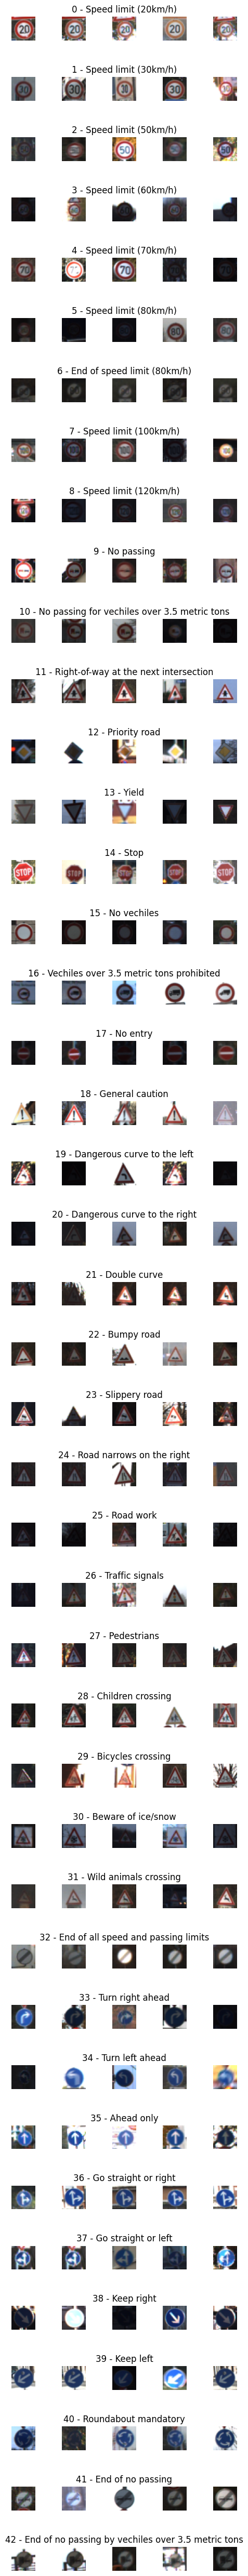

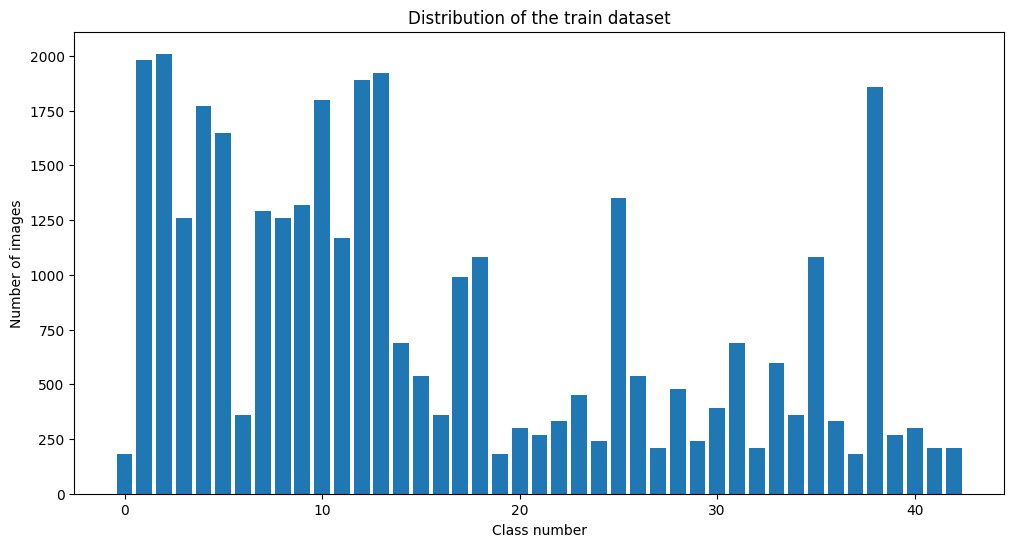

In [8]:
# Initialize an empty list to store the number of samples (images) per class
num_of_samples = []

# Define the number of columns for displaying images and the total number of classes
cols = 5
num_classes = 43

# Create subplots with a grid layout based on the number of classes and columns
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

# Iterate through each column (for displaying images in columns)
for i in range(cols):
    # Iterate through each row (each class of traffic sign) and access its index and row data
    for j, row in data.iterrows(): #j stores index of the current class, and row holds the data for that class, which is the sign name
        # Only select images from X_train that belong to the current class (j)
        x_selected = X_train[y_train == j]

        # Randomly select one image index from the selected images
        rand_index = random.randint(0, (len(x_selected) - 1))

        # Display the selected image in the corresponding subplot
        axs[j][i].imshow(x_selected[rand_index, :, :])

        # Turn off axis labels for cleaner visualization
        axs[j][i].axis("off")

        # Add class label and sign name as subplot title for the center column (i == 2)
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])

            # Count and store the number of samples (images) per class
            num_of_samples.append(len(x_selected))

# Plot a bar chart showing the distribution of the training dataset across classes
plt.figure(figsize=(12, 6))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

# Data Preprocessing

36
(32, 32, 3)
36


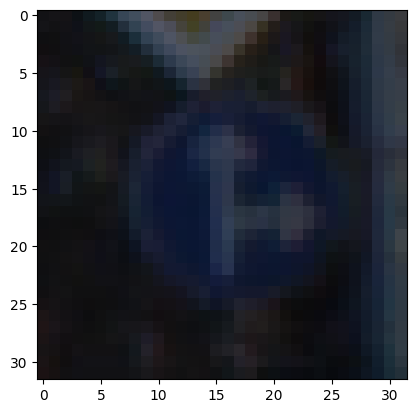

In [9]:
#Making sure everything is working
plt.imshow(X_train[1000])
print(y_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

In [10]:
# Create grayscale and equalization (which can help enhance contrast) functions
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


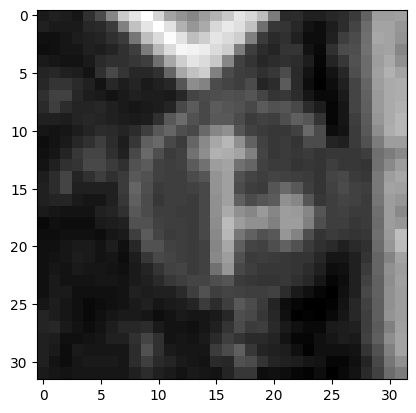

In [11]:
# Testing grayscale
img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray') #Without cmap image shows up as yellow/green due to lower level dependencies
print(img.shape)

(32, 32)


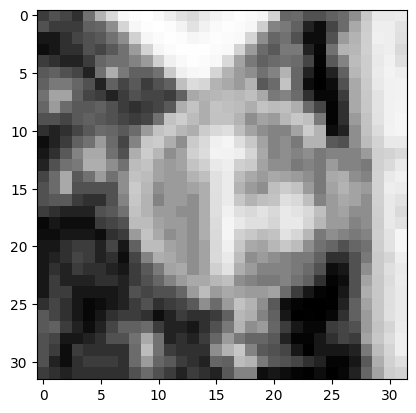

In [12]:
# Testing equalization
img = equalize(img)
plt.imshow(img, cmap='gray')
print(img.shape)

In [13]:
#Create preprocessing function

def preprocess(image):
    image = grayscale(image)
    image = equalize(image)
    image = image/255 #Standardize pixel values to be [0,1)
    return image

In [14]:
# Preprocess and convert each image in X_train/X_test/X_val to a numpy array
# Map is able to perform the function on every image. The map object is then converted to a list object so that it can then be converted back to numpy array/object
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


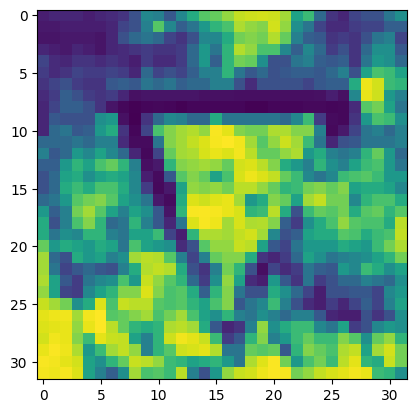

In [15]:
# Testing
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


In [17]:
# Reshape for later use in model training
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


# Data Augmentation and Batch Generator

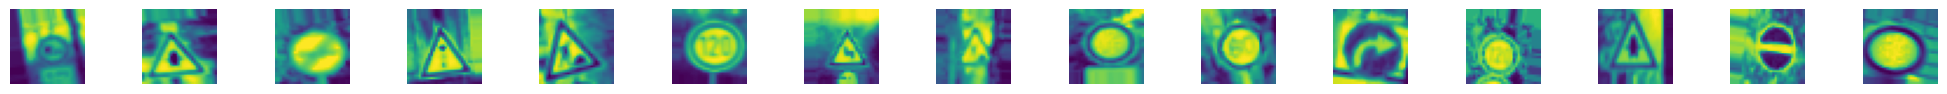

In [18]:
# Define augmentation parameters
datagen = ImageDataGenerator(
    width_shift_range=0.1,     # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,    # randomly shift images vertically (fraction of total height)
    zoom_range=0.2,            # randomly zoom into images
    shear_range=0.1,           # randomly apply shear transformation
    rotation_range=10.         # randomly rotate images within 10 degrees
)

# Fit the ImageDataGenerator to the training data
datagen.fit(X_train)

# Generate batches of augmented data
batches = datagen.flow(X_train, y_train, batch_size=15)

# Get a batch of augmented images and labels
X_batch, y_batch = next(batches)

# Create a plot to display the augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

# Display each augmented image in the batch
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))  # Reshape each image to (32, 32) for display
    axs[i].axis("off")  # Turn off axis labels

In [19]:
# Model will most likely only accept one-hot encoding (due to softmax activation function),
# and to_categorical will convert labels to one-hot; 5 --> [0, 0, 0, 0, 0, 1, 0...]
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [20]:
# Testing if one-hot worked
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(34799, 43)
(12630, 43)
(4410, 43)


# CNN Machine Learning Model

*   Using a slightly modified version of the LeNet architecture due to its robustness and efficiency

In [21]:
def model():
    model = Sequential() # Initialize a Sequential model

    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu')) # Convolutional layer with 60 filters, kernel size (5, 5), and ReLU activation function
    model.add(Conv2D(60, (5, 5), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling layer with pool size (2, 2) to down-sample the feature maps

    model.add(Conv2D(30, (3, 3), activation='relu')) # Convolutional layer with 30 filters, kernel size (3, 3), and ReLU activation function
    model.add(Conv2D(30, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling layer with pool size (2, 2) to down-sample the feature maps

    model.add(Flatten()) # Flatten layer to convert 2D arrays into a 1D vector

    model.add(Dense(500, activation='relu')) # Fully connected layer with 500 neurons and ReLU activation function

    model.add(Dropout(0.5)) # Dropout layer with dropout rate of 0.5 to prevent overfitting

    model.add(Dense(43, activation='softmax')) # Output layer with 43 neurons (corresponding to 43 classes) and softmax activation function

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [22]:
# Training the model using data augmentation generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=500,  # Number of batches to yield from generator per epoch
                              epochs=10,            # Number of epochs to train the model
                              validation_data=(X_val, y_val),  # Data on which to evaluate the loss and any model metrics at the end of each epoch
                              shuffle=1)            # Shuffle the training data before each epoch

Epoch 1/10
500/500 [==============================] - 19s 27ms/step - loss: 2.0118 - accuracy: 0.4336 - val_loss: 0.5235 - val_accuracy: 0.8435
Epoch 2/10
500/500 [==============================] - 14s 27ms/step - loss: 0.7403 - accuracy: 0.7754 - val_loss: 0.1670 - val_accuracy: 0.9476
Epoch 3/10
500/500 [==============================] - 12s 25ms/step - loss: 0.4486 - accuracy: 0.8607 - val_loss: 0.1007 - val_accuracy: 0.9673
Epoch 4/10
500/500 [==============================] - 13s 25ms/step - loss: 0.3314 - accuracy: 0.8969 - val_loss: 0.0791 - val_accuracy: 0.9762
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2669 - accuracy: 0.9174 - val_loss: 0.0593 - val_accuracy: 0.9850
Epoch 6/10
500/500 [==============================] - 14s 27ms/step - loss: 0.2255 - accuracy: 0.9298 - val_loss: 0.0612 - val_accuracy: 0.9810
Epoch 7/10
500/500 [==============================] - 13s 25ms/step - loss: 0.2127 - accuracy: 0.9330 - val_loss: 0.0782 - val_accuracy:

Text(0.5, 0, 'epoch')

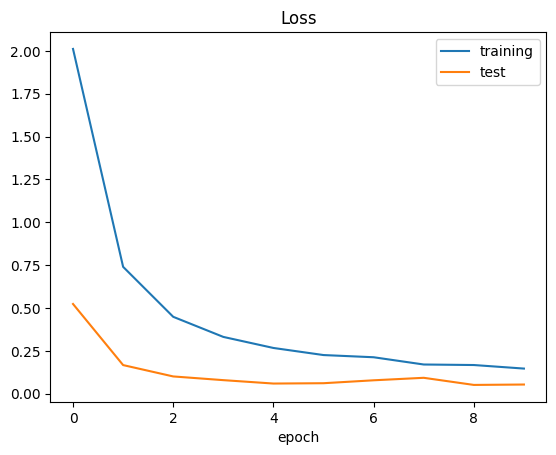

In [26]:
# Plot loss data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','test'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

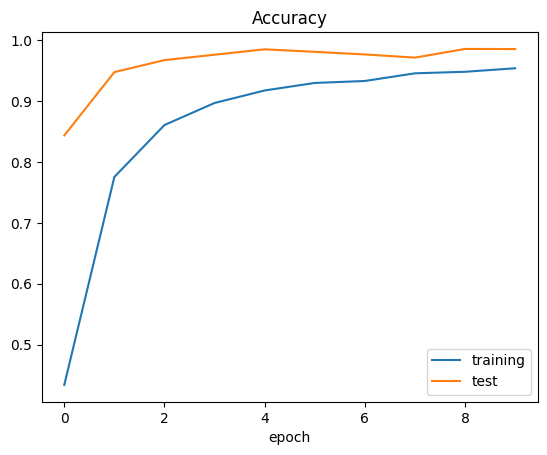

In [24]:
# Plot accuracy data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [27]:
# Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

395/395 [==============================] - 1s 4ms/step - loss: 0.1197 - accuracy: 0.9677
Test score: 0.119662344455719
Test accuracy: 0.967695951461792


# Data Analysis: Confusion Matrix and Classification Report

395/395 [==============================] - 1s 2ms/step


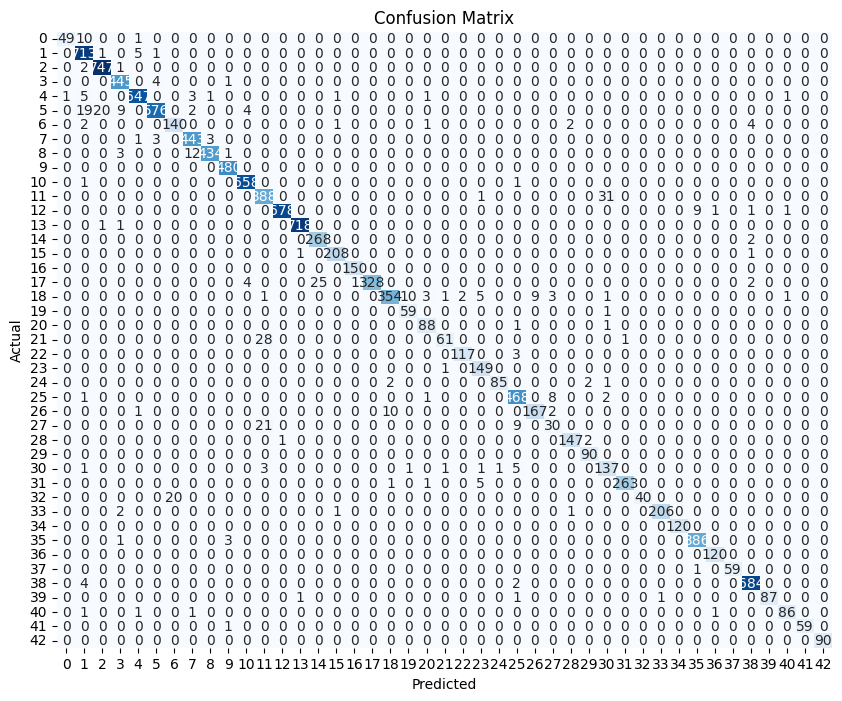

              precision    recall  f1-score   support

           0       0.98      0.82      0.89        60
           1       0.94      0.99      0.96       720
           2       0.97      1.00      0.98       750
           3       0.96      0.99      0.98       450
           4       0.99      0.98      0.98       660
           5       0.99      0.91      0.95       630
           6       0.88      0.93      0.90       150
           7       0.96      0.98      0.97       450
           8       0.99      0.96      0.98       450
           9       0.99      1.00      0.99       480
          10       0.99      1.00      0.99       660
          11       0.88      0.92      0.90       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.91      0.99      0.95       270
          15       0.99      0.99      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
y_pred = model.predict(X_test) # Predicts the output for X_test
y_pred_classes = np.argmax(y_pred, axis=1) # Converts predicted probabilities (y_pred) to class labels (y_pred_classes)
y_true = np.argmax(y_test, axis=1)  # Converts one-hot encoded y_test back to categorical labels (y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False) # Annotations set to true, fmt displays integers, and color bar is set to true
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))